In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
from scripts import *


In [71]:
#checkpoint = "experiments/dcgan_resnet/lightning_logs/version_0/checkpoints/epoch=524.ckpt"
checkpoint = "experiments/dcgan_disc_double_params_padding_reflect_lr_scheduler/lightning_logs/version_0/checkpoints/epoch=899.ckpt"
#checkpoint = "experiments/dataaug_2/lightning_logs/version_2/checkpoints/epoch=449.ckpt"
#checkpoint = "experiments/dcgan_disc_double_params_padding_reflect_lr_scheduler_slightly_larger/lightning_logs/version_0/checkpoints/epoch=949.ckpt"

potsdam_dir = "../potsdam_data/potsdam_cars_all"

In [72]:
model = GAN.load_from_checkpoint(checkpoint)
model.eval()
model.cuda()

GAN(
  (generator): BasicGenerator(
    (l1): Linear(in_features=100, out_features=4096, bias=True)
    (conv_blocks): Sequential(
      (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Upsample(scale_factor=2.0, mode=nearest)
      (2): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)

In [73]:
img_dim = model.hparams.img_dim[1:]
hue = [-0.1, 0.1]
contrast = [1, 1.25]
brightness = [1, 2]
data_augs = [
    # no dat aug
    transforms.Compose([transforms.Resize(img_dim),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5], [0.5])]),
    # horizontal flip only
    transforms.Compose([transforms.Resize(img_dim),
                        transforms.ToTensor(),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.Normalize([0.5], [0.5])]),
    # horizontal flip + hue
    transforms.Compose([transforms.Resize(img_dim),
                        transforms.ToTensor(),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.ColorJitter(hue=hue),
                        transforms.Normalize([0.5], [0.5])]),
    # horizontal flip + hue + contrast
    transforms.Compose([transforms.Resize(img_dim),
                        transforms.ToTensor(),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.ColorJitter(hue=hue, contrast=contrast),
                        transforms.Normalize([0.5], [0.5])]),
    # horizontal flip + hue + contrast + brightness
    transforms.Compose([transforms.Resize(img_dim),
                        transforms.ToTensor(),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.ColorJitter(
                            hue=hue, brightness=brightness, contrast=contrast),
                        transforms.Normalize([0.5], [0.5])]),
]

In [74]:
# data loaders
i = 0
dataset = ImageFolder(potsdam_dir, transform=data_augs[i])
potsdam_cars_dataloader = DataLoader(dataset, batch_size=4300, shuffle=True, num_workers=4)

In [75]:
real,_ = next(iter(potsdam_cars_dataloader))
act1 = np.squeeze(vgg16_get_activation_maps(
                real, layer_idx=33, device="cuda:0", normalize_range=(-1, 1)).numpy())

In [80]:
n_samples = 4*1024
bs = 64
truncation = 1
gen_in = th.normal(0, truncation, size=(
                            n_samples, model.generator.latent_dim), device=model.device)

# fake imgs need to do it in batches for memory stuff
fake = []
for i in range(n_samples // bs):
    si = i * bs
    ei = min((i+1)*bs, n_samples)
    fake.append(
        model(gen_in[si:ei]).detach().cpu().clone())
fake = th.cat(fake, dim=0) 

act2 = np.squeeze(vgg16_get_activation_maps(
                fake, layer_idx=33, device="cuda:0", normalize_range=(-1, 1)).numpy())

2.0171282

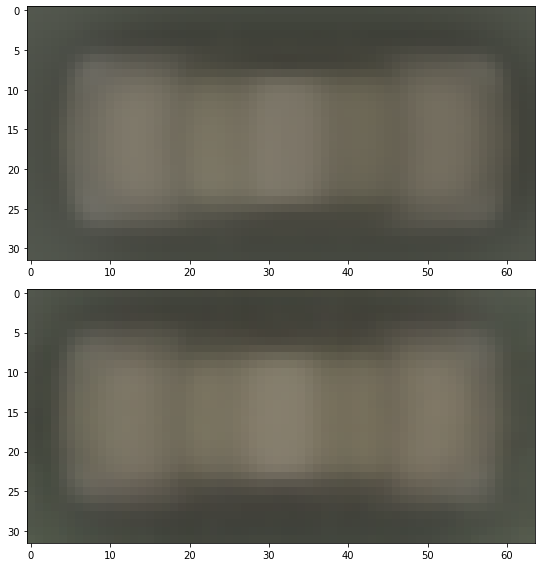

In [81]:
real_mean = (real.mean(axis=0).detach().cpu().numpy().transpose(1, 2, 0) + 1) / 2
fake_mean = (fake.mean(axis=0).detach().cpu().numpy().transpose(1, 2, 0) + 1) / 2

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.imshow(real_mean)
plt.subplot(2, 1, 2)
plt.imshow(fake_mean)
plt.tight_layout()

np.linalg.norm(real_mean - fake_mean)

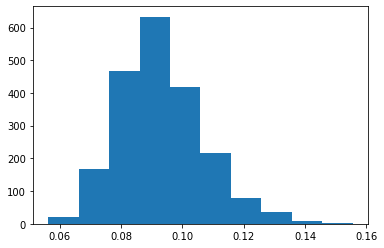

In [22]:
# norms inverse, replace inf values with 0
act1_norm = np.expand_dims(np.linalg.norm(act1, axis=1), 1)
act2_norm = np.expand_dims(np.linalg.norm(act2, axis=1), 1)
norms_inverse = 1 / (act2_norm.dot(act1_norm.T))

norms_inverse[np.isinf(norms_inverse)] = 0

# cos distance between two activations
cos_distances = (1 - norms_inverse*act2.dot(act1.T))
cos_distance = cos_distances.min(axis=1)  # min for each row
d = np.mean(cos_distance)

plt.hist(cos_distance)
plt.show()

In [25]:
jj = np.random.choice(len(fake), 50, replace=False)
#jj = np.argsort(cos_distance)[-50:]
#jj = np.argsort(cos_distance)[:50]
n = 10
imgs = []
for j in jj:
    idx = np.argsort(cos_distances[j])
    
    imgs.append(fake[j])
    for idx_ in idx[:n]:
        imgs.append(real[idx_])
        
grid = torchvision.utils.make_grid(imgs, nrow=n+1, normalize=True)
torchvision.utils.save_image(grid, "dcgan_resnet_v0_random.png")